In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import torch
import numpy as np
from models.ModularNetworks import PairwiseInteraction, Attention

from utils.couzin_utils import *
from utils.sim_utils import *
mpl.use('TkAgg')
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import Pool, set_start_method
from utils.train_utils import compute_wasserstein_loss, gradient_penalty
from torch.utils.data import TensorDataset, DataLoader, random_split
from utils.encoder_utils import *
from ema_pytorch import EMA
from pathlib import Path
from datetime import datetime

In [2]:
class Discriminator(nn.Module):
    def __init__(self, encoder, z_dim=32):
        super(Discriminator, self).__init__()
        self.encoder = encoder
        self.z_dim = z_dim
        self.input_dim = 2 * z_dim

        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def encoder_forward(self, tensor):
        states = tensor[..., :4]
        _, trans = self.encoder(states)
        batch, frames_minus_one, agent, neigh_rep = trans.shape
        feats = trans.reshape(batch * frames_minus_one * agent, neigh_rep)
        return feats, (batch, frames_minus_one, agent)

    def forward(self, tensor):
        features, shape = self.encoder_forward(tensor)
        batch, frames_minus_one, agent = shape

        params = torch.relu(self.fc1(features))
        params = torch.relu(self.fc2(params))
        params = torch.relu(self.fc3(params))
        params = self.fc4(params).squeeze(-1)

        params = params.view(batch, frames_minus_one, agent)
        scores = params.mean(dim=(1, 2))
        return scores

    def update(self, expert_batch, policy_batch, optim_dis, lambda_gp,
               noise=0, generation=None, num_generations=None):

        if noise > 0.0:
            noise_until = 0.5 * num_generations
            decay = 1.0 - (generation / noise_until)
            decay = max(0.0, decay)
            noise_term = noise * decay

            expert_batch = expert_batch.clone()
            policy_batch = policy_batch.clone()

            expert_batch = expert_batch + torch.randn_like(expert_batch) * noise_term 
            policy_batch = policy_batch + torch.randn_like(policy_batch) * noise_term

        exp_scores = self.forward(expert_batch)
        gen_scores = self.forward(policy_batch)

        grad_penalty = gradient_penalty(self, expert_batch, policy_batch)

        loss, loss_gp = compute_wasserstein_loss(exp_scores, gen_scores, lambda_gp, grad_penalty)

        optim_dis.zero_grad()
        loss_gp.backward()
        optim_dis.step()

        return {
            "dis_loss": round(loss.item(), 4),
            "dis_loss_gp": round(loss_gp.item(), 4),
            "grad_penalty": round(grad_penalty.item(), 4),
            "expert_score_mean": round(exp_scores.mean().item(), 4),
            "policy_score_mean": round(gen_scores.mean().item(), 4),
        }

    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()


In [3]:
class ModularPolicy(nn.Module):
    def __init__(self, features=4):
        super(ModularPolicy, self).__init__()

        self.pairwise = PairwiseInteraction(features)
        self.attention = Attention(features)

    def forward(self, states, deterministic=True):
        mu, sigma = self.pairwise(states)

        weights_logit = self.attention(states)
        weights = torch.softmax(weights_logit, dim=1)

        if deterministic:
            scaled_action = torch.sigmoid(mu)
            action = (scaled_action * weights).sum(dim=1)
            return action
        else:
            action = Normal(mu, sigma).rsample()
            scaled_action = torch.sigmoid(action)
            action = (scaled_action * weights).sum(dim=1)
            return action
        
    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()

In [4]:
#https://github.com/yiftachbeer/mmd_loss_pytorch/blob/master/mmd_loss.py

class RBF(nn.Module):

    def __init__(self, n_kernels=5, mul_factor=2.0, bandwidth=None):
        super().__init__()
        self.register_buffer(
            "bandwidth_multipliers",
            mul_factor ** (torch.arange(n_kernels) - n_kernels // 2)
        )
        self.bandwidth = bandwidth
        
    def get_bandwidth(self, L2_distances):
        if self.bandwidth is None:
            n_samples = L2_distances.shape[0]
            return L2_distances.data.sum() / (n_samples ** 2 - n_samples)
        return torch.as_tensor(self.bandwidth, device=L2_distances.device, dtype=L2_distances.dtype)

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2
        return torch.exp(-L2_distances[None, ...] / (self.get_bandwidth(L2_distances) * self.bandwidth_multipliers)[:, None, None]).sum(dim=0)


class MMDLoss(nn.Module):

    def __init__(self, encoder, kernel=RBF()):
        super().__init__()
        self.encoder = encoder
        self.kernel = kernel

    def encode_transitions(self, tensor):
        states = tensor[..., :4]
        _, transitions = self.encoder(states)
        features = transitions.reshape(-1, transitions.size(-1))
        return features

    def forward(self, expert_batch, generative_batch):
        X = self.encode_transitions(expert_batch)
        Y = self.encode_transitions(generative_batch)

        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()
        mmd_loss = XX - 2 * XY + YY
        return mmd_loss

In [5]:
def gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations,
                      rel_clip=0.01, abs_clip=None, min_clip=1e-12):
    grad = torch.zeros_like(theta)
    for eps, reward in zip(epsilons, rewards_norm):
        grad += eps * reward

    delta = (lr / (2 * sigma**2 * num_perturbations)) * grad

    theta_norm = theta.norm()
    max_delta_norm = rel_clip * theta_norm

    if abs_clip is not None:
        max_delta_norm = torch.minimum(max_delta_norm, theta.new_tensor(abs_clip))

    max_delta_norm = torch.maximum(max_delta_norm, theta.new_tensor(min_clip))

    dn = delta.norm() + 1e-12
    clip_ratio = (max_delta_norm / dn).clamp(max=1.0)
    delta = delta * clip_ratio

    return theta + delta


def discriminator_reward(discriminator, gen_tensor):
    scores = discriminator(gen_tensor)
    return scores.mean()


def optimize_es(policy, module, discriminator, lr, sigma, num_perturbations):

    network = policy.pairwise if module == 'pairwise' else policy.attention
    device = next(policy.parameters()).device
    
    theta = nn.utils.parameters_to_vector(network.parameters()).detach().clone()
    dim = theta.numel()

    seeds = np.random.randint(0, 100000, size=num_perturbations)

    reward_diffs = []
    epsilons = []

    disc_device = next(discriminator.parameters()).device

    for perturbation in range(num_perturbations):

        seed = seeds[perturbation]

        eps = torch.randn(dim, device=theta.device, dtype=theta.dtype) * sigma
        epsilons.append(eps)

        with torch.no_grad():
            nn.utils.vector_to_parameters(theta + eps, network.parameters())
            _, pos_prey_tensor = run_env_simulation(visualization='off', prey_policy=policy, pred_policy=None,
                                                    n_prey=32, n_pred=0, 
                                                    max_steps=100, seed=seed,
                                                    pred_speed=5, prey_speed=5,
                                                    area_width=50, area_height=50, device=device)
            pos_prey_tensor = pos_prey_tensor.unsqueeze(0).to(device=disc_device)
            pos_reward = discriminator_reward(discriminator, pos_prey_tensor)

            nn.utils.vector_to_parameters(theta - eps, network.parameters())
            _, neg_prey_tensor = run_env_simulation(visualization='off', prey_policy=policy, pred_policy=None,
                                                    n_prey=32, n_pred=0, 
                                                    max_steps=100, seed=seed,
                                                    pred_speed=5, prey_speed=5,
                                                    area_width=50, area_height=50, device=device)
            neg_prey_tensor = neg_prey_tensor.unsqueeze(0).to(device=disc_device)
            neg_reward = discriminator_reward(discriminator, neg_prey_tensor)

            nn.utils.vector_to_parameters(theta, network.parameters())

            reward_diffs.append((pos_reward.mean() - neg_reward.mean()).detach())

    diffs = torch.stack(reward_diffs).to(theta.device)
    rewards_norm = (diffs - diffs.mean()) / (diffs.std(unbiased=False) + 1e-8)

    theta_est = gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations)

    # if std is too small, do not update (Random Walk)
    if diffs.std(unbiased=False) < 1e-6:
        theta_est = theta

    nn.utils.vector_to_parameters(theta_est, network.parameters())
    
    return {"diff_min": round(diffs.min().item(), 6),
            "diff_max": round(diffs.max().item(), 6),
            "diff_mean": round(diffs.mean().item(), 6),
            "diff_std": round(diffs.std(unbiased=False).item(), 6),
            "delta_norm": round((theta_est - theta).norm().item(), 6)}


def mae_actions(expert_batch, generative_batch):
    a_exp = expert_batch[..., 4]
    a_gen = generative_batch[..., 4]
    return torch.mean(torch.abs(a_exp - a_gen)).item()


def pretrain_policy(policy, expert_data, batch_size=256, epochs=250, lr=1e-3, deterministic=True, device='cpu'):
    policy.to(device)
    policy.train()

    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    frames, agents, neigh, features = expert_data.shape
    expert_data = expert_data.reshape(frames * agents, neigh, features)
    
    states = expert_data[..., :4]
    actions = expert_data[:, 0, 4]

    dataset = TensorDataset(states, actions)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(1, epochs + 1):
        epoch_loss = 0

        for s, a in loader:
            states = s.to(device)
            actions = a.to(device)

            action = policy.forward(states, deterministic=deterministic)

            if action.dim() == 2 and action.size(-1) == 1:
                action = action.squeeze(-1) 

            loss = F.mse_loss(action, actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * a.size(0)

        if epoch % 25 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / (frames * agents):.6f}")

    return policy

In [6]:
# Training
num_generations = 800
gamma = 0.999

# Policy
lr_policy = 0.001
num_perturbations = 32
sigma = 0.15
deterministic=True

# Discriminator
dis_balance_factor = 5
noise = 0.01
lr_disc = 0.0001
lambda_gp = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
#mpl.use('TkAgg')
_, exp_tensor, _ = run_couzin_simulation(visualization="off", max_steps=500, alpha=0.01, 
                                         constant_speed=5, shark_speed=5, 
                                         area_width=50, area_height=50,
                                         number_of_sharks=0, n=32)

In [8]:
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)
encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
projector = VicRegProjector(input_dim=64).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(projector.parameters()), lr=1e-3, weight_decay=1e-6)

train_encoder(encoder, projector, aug=aug, exp_tensor=exp_tensor, epochs=1000, optimizer=optimizer, device=device)

epoch 010: loss=23.718269 sim=0.0559 std=1.3867 cov=0.3042 std_mean=0.307
epoch 020: loss=22.484104 sim=0.0503 std=1.2999 cov=0.3454 std_mean=0.350
epoch 030: loss=21.751186 sim=0.0547 std=1.2270 cov=0.3961 std_mean=0.387
epoch 040: loss=21.200861 sim=0.0597 std=1.1761 cov=0.4136 std_mean=0.412
epoch 050: loss=20.661865 sim=0.0663 std=1.1273 cov=0.4188 std_mean=0.436
epoch 060: loss=20.190653 sim=0.0715 std=1.0739 cov=0.4589 std_mean=0.463
epoch 070: loss=19.888655 sim=0.0782 std=1.0411 cov=0.4632 std_mean=0.479
epoch 080: loss=19.585361 sim=0.0837 std=1.0110 cov=0.4656 std_mean=0.494
epoch 090: loss=19.311623 sim=0.0893 std=0.9790 cov=0.4787 std_mean=0.510
epoch 100: loss=19.023632 sim=0.0940 std=0.9497 cov=0.4854 std_mean=0.525
epoch 110: loss=18.803307 sim=0.0952 std=0.9226 cov=0.5172 std_mean=0.539
epoch 120: loss=18.592154 sim=0.1008 std=0.8966 cov=0.5246 std_mean=0.552
epoch 130: loss=18.417173 sim=0.1037 std=0.8727 cov=0.5469 std_mean=0.564
epoch 140: loss=18.233620 sim=0.1082 s

In [9]:
for p in encoder.parameters():
    p.requires_grad = False 

expert_batch = sample_data(exp_tensor, consecutive_frames=10, batch_size=10).to(device)
states = expert_batch[..., :4]
zt, trans = encoder(states)

Window embeddings: (6400, 32)
Transition embeddings: (200000, 64)


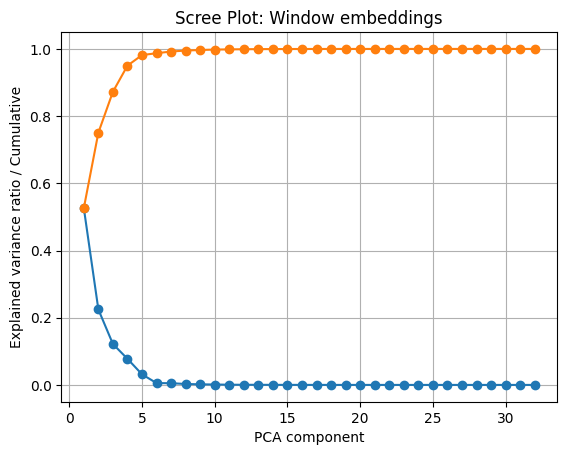

[Window embeddings] best_k by silhouette on subsample: 2 (sil=0.4403)


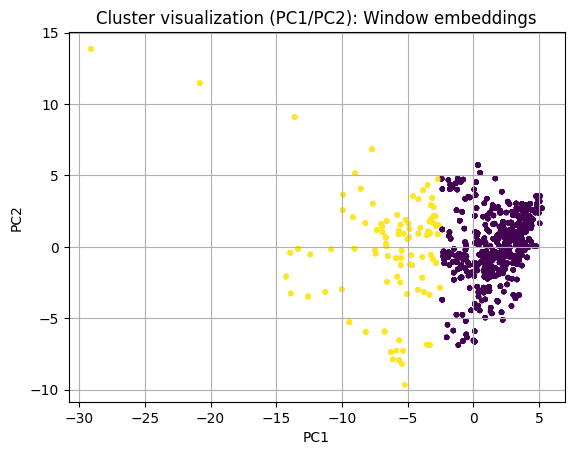

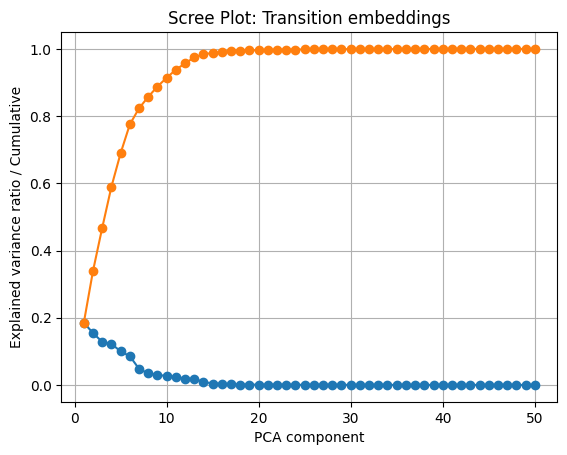

[Transition embeddings] best_k by silhouette on subsample: 2 (sil=0.1104)


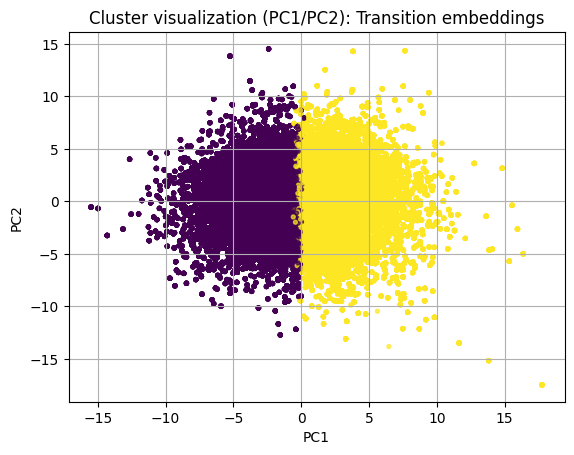

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# -----------------------
# 1) Embeddings sammeln
# -----------------------
encoder.eval()
for p in encoder.parameters():
    p.requires_grad = False

# Konfig
T = 10                    # consecutive_frames
B = 32                    # batch_size pro sample_data call
N_ITERS = 200             # wie viele batches sammeln (B*N_ITERS windows)
MAX_TRANS_SAMPLES = 200_000  # transitions runter-samplen, sonst wird es riesig
SEED = 0

rng = np.random.default_rng(SEED)

window_emb_list = []
trans_emb_list = []

with torch.no_grad():
    for it in range(N_ITERS):
        expert_batch = sample_data(exp_tensor, consecutive_frames=T, batch_size=B).to(device)  # [B,T,A,N,Feat]
        states = expert_batch[..., :4]  # wie bei dir

        # encoder output (bei dir: zt, trans)
        zt, trans = encoder(states)
        # Erwartete Shapes (typisch):
        # zt   : [B, T,   A, z]
        # trans: [B, T-1, A, 2z]   (concat(z_t, dz)) o.ä.

        # --- Window embedding (pro Window ein Vektor) ---
        # Pool über Zeit+Agenten -> [B, z] (oder [B, D])
        # (falls zt andere dims hat, dims hier anpassen)
        win_emb = zt.mean(dim=(1, 2))  # [B, z]
        window_emb_list.append(win_emb.detach().cpu())

        # --- Transition embedding (pro Transition ein Vektor) ---
        tr = trans.reshape(-1, trans.shape[-1])  # [B*(T-1)*A, 2z]
        trans_emb_list.append(tr.detach().cpu())

# Stack zu numpy
X_win = torch.cat(window_emb_list, dim=0).numpy()  # [N_windows, D]
X_tr  = torch.cat(trans_emb_list,  dim=0).numpy()  # [N_transitions, D]

# transitions optional runter-samplen (sonst sehr viele Punkte)
if X_tr.shape[0] > MAX_TRANS_SAMPLES:
    idx = rng.choice(X_tr.shape[0], size=MAX_TRANS_SAMPLES, replace=False)
    X_tr = X_tr[idx]

print("Window embeddings:", X_win.shape)
print("Transition embeddings:", X_tr.shape)


# -----------------------------------------
# 2) PCA ScreePlot + Clustering + Plotting
# -----------------------------------------
def run_pca_cluster_viz(
    X,
    title="",
    max_pca_dim=50,
    cluster_pca_dim=20,
    k_range=range(2, 11),
    silhouette_subsample=10_000,
    random_state=0,
):
    # --- Standardize ---
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # --- PCA fit ---
    n_comp = min(max_pca_dim, Xs.shape[1])
    pca = PCA(n_components=n_comp, random_state=random_state)
    Z = pca.fit_transform(Xs)  # [N, n_comp]

    # --- Scree plot ---
    evr = pca.explained_variance_ratio_
    cev = np.cumsum(evr)

    plt.figure()
    plt.plot(np.arange(1, len(evr) + 1), evr, marker="o")
    plt.plot(np.arange(1, len(cev) + 1), cev, marker="o")
    plt.xlabel("PCA component")
    plt.ylabel("Explained variance ratio / Cumulative")
    plt.title(f"Scree Plot: {title}")
    plt.grid(True)
    plt.show()

    # --- Clustering in PCA-space (first d dims) ---
    d = min(cluster_pca_dim, Z.shape[1])
    Zc = Z[:, :d]

    # silhouette sweep (auf subsample, sonst langsam)
    if Zc.shape[0] > silhouette_subsample:
        sub_idx = rng.choice(Zc.shape[0], size=silhouette_subsample, replace=False)
        Zs_sub = Zc[sub_idx]
    else:
        Zs_sub = Zc

    best_k, best_s = None, -1
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        lab = km.fit_predict(Zs_sub)
        # silhouette braucht >=2 cluster
        s = silhouette_score(Zs_sub, lab)
        if s > best_s:
            best_s = s
            best_k = k

    print(f"[{title}] best_k by silhouette on subsample: {best_k} (sil={best_s:.4f})")

    kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=random_state)
    labels = kmeans.fit_predict(Zc)

    # --- 2D visualization using first 2 PCs (nur Plot) ---
    plt.figure()
    plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=8, alpha=0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Cluster visualization (PC1/PC2): {title}")
    plt.grid(True)
    plt.show()

    return {
        "scaler": scaler,
        "pca": pca,
        "kmeans": kmeans,
        "labels": labels,
        "Z": Z,
    }


# ------------- Run for both -------------
res_win = run_pca_cluster_viz(
    X_win,
    title="Window embeddings",
    max_pca_dim=50,
    cluster_pca_dim=20,
)

res_tr = run_pca_cluster_viz(
    X_tr,
    title="Transition embeddings",
    max_pca_dim=50,
    cluster_pca_dim=20,
)


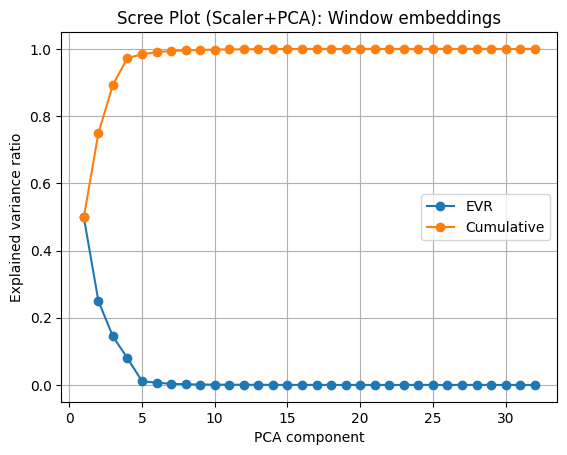

[Window embeddings] best_k by silhouette on subsample: 2 (sil=0.4357)


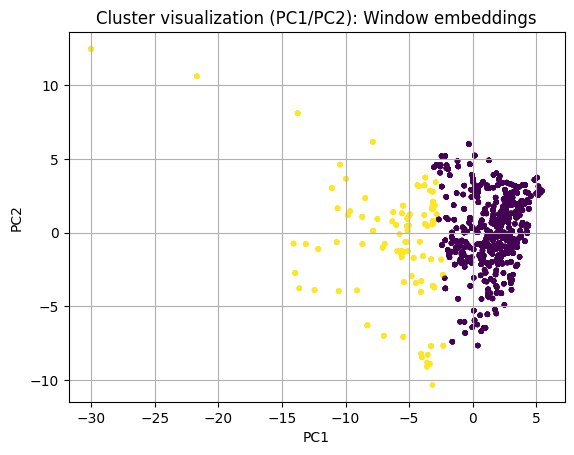

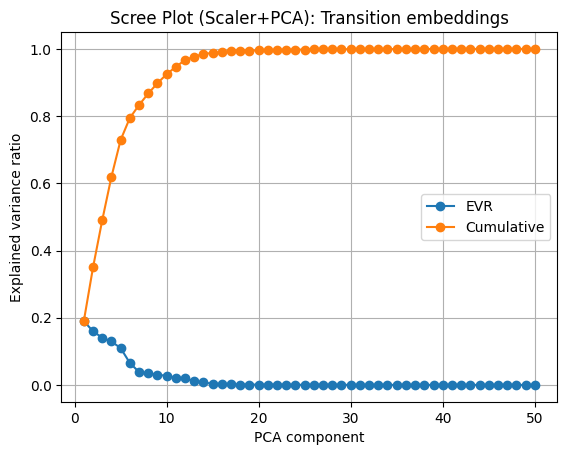

[Transition embeddings] best_k by silhouette on subsample: 2 (sil=0.1151)


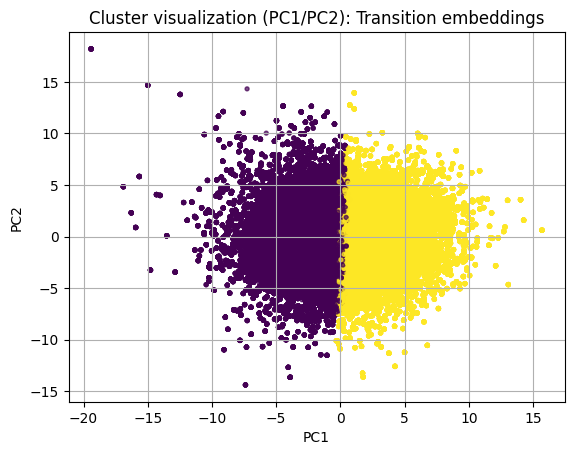

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def run_pca_cluster_viz_with_scaler(
    X,
    title="",
    max_pca_dim=50,
    cluster_pca_dim=20,
    k_range=range(2, 11),
    silhouette_subsample=10_000,
    random_state=0,
    l2_normalize_before_scaler=True,
):
    """
    X: np.ndarray [N, D]
    - optional L2-normalize each row (recommended for embeddings)
    - StandardScaler
    - PCA (Scree Plot)
    - KMeans with best_k via silhouette on subsample
    - 2D cluster visualization on PC1/PC2
    """
    X = np.asarray(X, dtype=np.float32)

    # --- Optional: L2-normalize per sample (often helps for embedding clustering)
    if l2_normalize_before_scaler:
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        X = X / (norms + 1e-12)

    # --- Standardize
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # --- PCA
    n_comp = min(max_pca_dim, Xs.shape[1])
    pca = PCA(n_components=n_comp, random_state=random_state)
    Z = pca.fit_transform(Xs)

    # --- Scree plot
    evr = pca.explained_variance_ratio_
    cev = np.cumsum(evr)

    plt.figure()
    plt.plot(np.arange(1, len(evr) + 1), evr, marker="o", label="EVR")
    plt.plot(np.arange(1, len(cev) + 1), cev, marker="o", label="Cumulative")
    plt.xlabel("PCA component")
    plt.ylabel("Explained variance ratio")
    plt.title(f"Scree Plot (Scaler+PCA): {title}")
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Clustering in PCA space (first d PCs)
    d = min(cluster_pca_dim, Z.shape[1])
    Zc = Z[:, :d]

    # silhouette sweep on subsample
    rng = np.random.default_rng(random_state)
    if Zc.shape[0] > silhouette_subsample:
        sub_idx = rng.choice(Zc.shape[0], size=silhouette_subsample, replace=False)
        Zs_sub = Zc[sub_idx]
    else:
        Zs_sub = Zc

    best_k, best_s = None, -1
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        lab = km.fit_predict(Zs_sub)
        s = silhouette_score(Zs_sub, lab)
        if s > best_s:
            best_s = s
            best_k = k

    print(f"[{title}] best_k by silhouette on subsample: {best_k} (sil={best_s:.4f})")

    kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=random_state)
    labels = kmeans.fit_predict(Zc)

    # --- 2D visualization (PC1/PC2)
    plt.figure()
    plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=8, alpha=0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Cluster visualization (PC1/PC2): {title}")
    plt.grid(True)
    plt.show()

    return {
        "scaler": scaler,
        "pca": pca,
        "kmeans": kmeans,
        "labels": labels,
        "Z": Z,
        "l2_normalize_before_scaler": l2_normalize_before_scaler,
    }


# ---- Usage ----
res_win = run_pca_cluster_viz_with_scaler(X_win, title="Window embeddings",  max_pca_dim=50, cluster_pca_dim=10)
res_tr  = run_pca_cluster_viz_with_scaler(X_tr,  title="Transition embeddings", max_pca_dim=50, cluster_pca_dim=20)

